# Model Tuning #

In [1]:
# Import libraries necessary for this project
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import usefull_methods as um
import do_actions as do

from stopwatch import Stopwatch
stopwatch = Stopwatch()

# Pretty display for notebooks
%matplotlib inline


In [2]:
def print_shape(data, name):
    print("{0}: {1}".format(name, data.shape))
    
def print_versions(data1, data2, idx ):
    print("TEST[{2}]  {0} == {1}".format(data1[idx], data2[idx], idx))
    
def print_model_param(drop_columns_, do_dummies_, unskew_data_, do_scaling_):
    if drop_columns_:
        print("DROP FEATURES  is ON")
    else:
        print("DROP FEATURES  is OFF")

    if do_dummies_:
        print("ONE HOT ENCODE is ON")
    else:
        print("ONE HOT ENCODE is OFF")

    if unskew_data_:
        print("UNSKEW DATA    is ON")
    else:
        print("UNSKEW DATA    is OFF")

    if do_scaling_:
        print("SCALING        is ON")
    else:
        print("SCALING        is OFF")
       

# Handle Missing Data#

In [3]:
def show_missing(data):
    # df.isnull() Return a boolean same-sized object indicating if the values are null.
    # df.any() Return whether any element is True over requested axis
    #
    missing = data.columns[data.isnull().any()].tolist()
    return missing

# Looking at categorical values
def cat_exploration(data, column):
    return data[column].value_counts()

# deleting missing data
def handle_missing(data, column, value):
    data.loc[data[column].isnull(),column] = value
    return data

def count_missing(data):
    data[show_missing(data)].isnull().sum()

In [4]:
def do_handle_missing_data(data):
    data = handle_missing(data, 'PoolQC', 'None')
    data = handle_missing(data, 'MiscFeature', 'None' )
    data = handle_missing(data, 'Alley', 'None' )
    data = handle_missing(data, 'Fence', 'None' )
    data = handle_missing(data, 'FireplaceQu', 'None' )
    data = handle_missing(data, 'LotFrontage', 0.0 )
    
    data = handle_missing(data, 'GarageType', 'None' )
    data = handle_missing(data, 'GarageYrBlt', 0.0 )
    data = handle_missing(data, 'GarageFinish', 'None' )
    data = handle_missing(data, 'GarageQual', 'None' )
    data = handle_missing(data, 'GarageCond', 'None' )
    data = handle_missing(data, 'GarageArea', 0.0 )
    data = handle_missing(data, 'GarageCars', 'None' )
 
    data = handle_missing(data, 'BsmtQual', 'None' )
    data = handle_missing(data, 'BsmtCond', 'None' )
    data = handle_missing(data, 'BsmtExposure', 'None' )
    data = handle_missing(data, 'BsmtFinType1', 'None' )
    data = handle_missing(data, 'BsmtFinType2', 'None' )
    
    data = handle_missing(data, 'BsmtFinSF1', 0.0)
    data = handle_missing(data, 'BsmtFinSF2', 0.0 )
    data = handle_missing(data, 'BsmtFullBath', 'None' )
    data = handle_missing(data, 'BsmtHalfBath', 'None' )
    data = handle_missing(data, 'BsmtUnfSF', 0.0 )
    
    data = handle_missing(data, 'TotalBsmtSF', 0.0 )
    data = handle_missing(data, 'MasVnrArea', 0.0 )
    
    # missing data replaced by most frequent value
    data = handle_missing(data, 'MasVnrType', 'None' )
    data = handle_missing(data, 'Electrical','SBrkr' )
    data = handle_missing(data, 'Functional','Typ' )
    data = handle_missing(data, 'KitchenQual','TA' )
    data = handle_missing(data, 'MSZoning','RL' )
    data = handle_missing(data, 'Exterior1st','VinylSd' )
    data = handle_missing(data, 'Exterior2nd','VinylSd' )    
    data = handle_missing(data, 'SaleType','WD' )
    
    # not in training set
    data = data.drop(['Utilities'], axis=1)
    
    return data

# Handle Categorical  Data #

In [5]:
categoricaldata = ('MiscFeature', 'Alley', 'Fence', 'FireplaceQu', 'PoolQC',
                       'Street', 'BsmtCond', 'GarageCond', 'GarageQual',
                      'BsmtQual', 'CentralAir', 'ExterQual', 'ExterCond', 'HeatingQC',
                      'KitchenQual', 'BsmtFinType1','BsmtFinType2', 'Functional',
                      'BsmtExposure', 'GarageFinish','LandSlope', 'LotShape', 'MSZoning',
                      'LandContour', 'LotConfig', 'Neighborhood', 'Condition1',
                      'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st',
                      'Exterior2nd', 'MasVnrType', 'Foundation', 'Heating', 'Electrical', 'GarageType',
                      'PavedDrive', 'SaleType', 'SaleCondition')


# Data Skew #

In [6]:
import seaborn as sns

def plot_distribution(data, label):
    # set size of the graph
    plt.subplots(figsize=(20, 7))
    ax = sns.distplot(data, color="g", kde=True )
    ax.axvline(np.mean(data),linewidth=1, color='b')
    ax.axvline(np.median(data),linewidth=1, color='r')

    plt.title("Distribution of {}".format(label))
    plt.ylabel("Number of Occurences")
    plt.xlabel(label);
    plt.show()

In [7]:
from scipy.special import boxcox1p

def check_skewed(data, treshold):
    skewcheck = data.dtypes[data.dtypes != "object"].index
    skewed = data[skewcheck].skew().sort_values(ascending=False)
    skew_df = pd.DataFrame(skewed)
    skew_df = abs(skew_df)
    skew_df = skew_df[skew_df > treshold]
    skew_df = skew_df.dropna()
    return skew_df

def unskew_boxcox1p(data, skew_df, lm):
    needs_fixing = skew_df.index
    for x in needs_fixing:
        data[x] = boxcox1p(data[x], lm)
        #data[x] += 1
    return data

def unskew_boxcox1p_all(data, lm):
    return boxcox1p(data, lm)

from scipy.special import inv_boxcox1p

def skew_inv_boxcox1p(data, lm):
    return inv_boxcox1p(data, lm)
    
print("accepted")    

accepted


# Data Drop #

In [8]:
def do_remove_outliers_simple(data):
    data = data.drop(data[(data['GrLivArea']>4000) & (data['SalePrice']<300000)].index)
    return data

def do_outliers_Ids(data):
    a = data['GrLivArea']>4000
    b = data['SalePrice']<300000
    f = [a, b]
    return pd.concat(f)

# Standardization #

In [9]:

scalerdata = ['1stFlrSF', '2ndFlrSF', '3SsnPorch', 'BedroomAbvGr', 'BsmtFinSF1', 
                 'BsmtFinSF2', 'BsmtUnfSF', 'EnclosedPorch', 
                 'Fireplaces',  'GarageYrBlt', 'HalfBath', 'FullBath',
                 'GrLivArea',  'KitchenAbvGr', 'LotArea', 'LotFrontage', 
                 'LowQualFinSF', 'MSSubClass', 'MasVnrArea', 'MiscVal', 'MoSold', 'OpenPorchSF', 
                 'OverallCond', 'OverallQual', 'PoolArea', 'ScreenPorch', 
                 'TotRmsAbvGrd', 'TotalBsmtSF', 'WoodDeckSF', 'YearBuilt', 'YearRemodAdd', 'YrSold']

#   'GarageCars', 'SalePrice', 'BsmtFullBath', 'BsmtHalfBath', 

from sklearn.preprocessing import StandardScaler


# Model #

In [10]:
stopwatch.start()
data_train, data_test = um.load_data()

print_shape( data_train, 'data_train')
print_shape( data_test, 'data_test')

# get outliers Id, will be removed later
data_train = do.remove_this_Ids(data_train, [524, 1299])

# target variable, preserve and remove from data
target_train = data_train[['SalePrice','Id']]
data_train = data_train.drop(['SalePrice'], axis = 1)


# concatenate test and train data
train_ids = data_train['Id']
test_ids = data_test['Id']

print_shape( train_ids, 'train_ids')
print_shape( test_ids, 'test_ids')

all_data = pd.concat([data_train, data_test])
all_ids = all_data['Id']

all_data = do_handle_missing_data(all_data)
all_data = do.add_TotalSF(all_data)

dropcolumns = ('BsmtFinSF2','BsmtHalfBath','MiscVal','LowQualFinSF', 'YrSold', 'OverallCond', 'MSSubClass', 'EnclosedPorch',
 'KitchenAbvGr',   'BsmtFullBath', 'BsmtUnfSF', 'BedroomAbvGr', 'ScreenPorch',  'MoSold', '3SsnPorch')

# LABEL ENCODER
all_data = do.encode_categorical(all_data, categoricaldata)

# DROP SOME DATA  & DO ONE HOT ENCODING
drop_columns = False
do_dummies = True
if drop_columns:
    all_data = all_data.drop(list(dropcolumns), axis = 1)
    to_dummies = set(categoricaldata) - set(dropcolumns)
    if do_dummies:
        all_data = pd.get_dummies(all_data, columns=list(to_dummies))
else:
    if do_dummies:
        all_data = pd.get_dummies(all_data, columns=list(categoricaldata))

keep_cols = all_data.select_dtypes(include = ['number']).columns
all_data = all_data[keep_cols]

all_data_untransformed = all_data.copy()
target_untransformed = target_train.copy()

# UNSKEW
unskew_data = True
if unskew_data:
    skewed_data = check_skewed(all_data, 0.75)
    all_data = unskew_boxcox1p(all_data, skewed_data, 0.25)
    target_train = boxcox1p(target_train, 0.25)

print_shape( all_data, 'all_data')
    
# STANDARDIZATION
do_scaling = True
if do_scaling:
    # scale features
    scaler = StandardScaler()
    scaler.fit(all_data[scalerdata])
    all_data[scalerdata] = scaler.transform(all_data[scalerdata])
    # scale target variable
    if True:
        scaler2 = StandardScaler()
        X = target_train['SalePrice'].values.reshape(-1,1)
        scaler2.fit(X)
        target_train_scaled = scaler2.transform(X)
        target_train['SalePrice'] = target_train_scaled
        # check with inverse
        inv_X = scaler2.inverse_transform(target_train_scaled)
        #print(np.isclose(inv_X.astype(np.float),X.astype(np.float)))

    
print_shape( all_data, 'all_data')

all_data['Id'] = all_ids

features_train = all_data[all_data['Id'].isin(train_ids)]
features_test = all_data[all_data['Id'].isin(test_ids)]
print_shape( features_train, 'features_train')
print_shape( features_test, 'features_test')

#features_train = features_train.drop(features_train['Id'].isin(outliers_ids))
#target_train = target_train.drop(target_train['Id'].isin(outliers_ids))

features_train = features_train.drop(['Id'], axis = 1)
features_test = features_test.drop(['Id'], axis = 1)
target_train = target_train.drop(['Id'], axis = 1)
target_train = target_train['SalePrice'].values

print_shape( features_train, 'features_train')
print_shape( features_test, 'features_test')
print_shape( target_train, 'target_train')

print(features_train.columns[features_train.isnull().any()])
print(features_test.columns[features_test.isnull().any()])

features_test.head()

features = features_train
target = target_train

target_normal = target_untransformed['SalePrice'].values

print_model_param(drop_columns, do_dummies, unskew_data, do_scaling)

data_train: (1460, 81)
data_test: (1459, 80)
train_ids: (1458,)
test_ids: (1459,)
all_data: (2917, 298)
all_data: (2917, 298)
features_train: (1458, 298)
features_test: (1459, 298)
features_train: (1458, 297)
features_test: (1459, 297)
target_train: (1458,)
Index([], dtype='object')
Index([], dtype='object')
DROP FEATURES  is OFF
ONE HOT ENCODE is ON
UNSKEW DATA    is ON
SCALING        is ON


In [14]:
def inverse_transform_single(data_pred_raw_, do_scaling_, unskew_data_):
    lm = 0.25
    if do_scaling_:
        data_pred_unscaled = scaler2.inverse_transform(data_pred_raw_)
    else:
        data_pred_unscaled = data_pred_raw_
    if unskew_data_:
        data_pred_normal_ = skew_inv_boxcox1p(data_pred_unscaled, lm)
    else:
        data_pred_normal_ = data_pred_unscaled
    return data_pred_normal_

# Metrics #

In [15]:
import sklearn
import numpy as np

from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

def RMSE(y, y_pred):
    return np.sqrt(np.sum(np.square(y_pred-y))/len(y))

def RMSElog(y, y_pred):
    y = np.log(y)
    y_pred = np.log(y_pred)
    return np.sqrt(np.sum(np.square(y_pred-y))/len(y))

def calc_metrics(y, y_pred):
    r2score = r2_score(y, y_pred)
    rmse_log = RMSElog(y, y_pred)
    rmse = RMSE(y, y_pred)
    return rmse, rmse_log,  r2score

def print_metrics (rmse, rmse_log,r2score):
    print('RMSE               : {:.4f}'.format(rmse, prec=5))
    print('RMSE of logarithms : {:.4f}'.format(rmse_log, prec=5))
    print('R2 score           : {:.6f}'.format(r2score, prec = 5))
    
def show_metrics(y, y_pred):
    rmse, rmse_log, r2score = calc_metrics(y, y_pred)
    print_metrics(rmse, rmse_log, r2score )
    return rmse, rmse_log, r2score
       

# Neural Network Model  in Keras #

In [16]:
import numpy
import pandas
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

Using Theano backend.


In [17]:
# custom R2-score metrics for keras backend
from keras import backend as K

def r2_keras(y_true, y_pred):
    SS_res =  K.sum(K.square(y_true - y_pred)) 
    SS_tot = K.sum(K.square(y_true - K.mean(y_true))) 
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )

In [18]:
# define base model
def baseline_model():
    # create model
    model = Sequential()
    model.add(Dense(100, input_dim=297, kernel_initializer='normal', activation='relu'))
    #model.add(Dense(100, input_dim=297, kernel_initializer='normal', activation='relu'))
    model.add(Dense(1, kernel_initializer='normal'))
    # Compile model
    model.compile(loss='mean_squared_error', optimizer='adam')
    #model.compile(loss='r2', optimizer='adam')
    return model

In [19]:
# define the model
def larger_model():
    # create model
    model = Sequential()
    model.add(Dense(297, input_dim=297, kernel_initializer='normal', activation='relu'))
    model.add(Dense(100, kernel_initializer='normal', activation='relu'))
    model.add(Dense(50, kernel_initializer='normal', activation='relu'))
    model.add(Dense(1, kernel_initializer='normal'))
    # Compile model
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

In [20]:
seed = 1564
kfold = KFold(n_splits=10, random_state=seed)

# Reggression #

In [21]:
stopwatch.start()
seed = 2465
numpy.random.seed(seed)

print_model_param(drop_columns, do_dummies, unskew_data, do_scaling)

X = features.values
Y = target

regressor = KerasRegressor(build_fn=larger_model, epochs=100, batch_size=2, verbose=0)
y_pred_raw = cross_val_predict(regressor, X, Y, cv=kfold)

stopwatch.print_elapsed_time()


DROP FEATURES  is OFF
ONE HOT ENCODE is ON
UNSKEW DATA    is ON
SCALING        is ON

Elapsed time: 01:03:14



In [22]:
y_pred = inverse_transform_single(y_pred_raw, do_scaling, unskew_data)

show_metrics(target_normal, y_pred)

RMSE               : 23379.6353
RMSE of logarithms : 0.1270
R2 score           : 0.913445


(23379.635342142119, 0.12699177238390244, 0.91344479148252189)

RMSE               : 23693.3557
RMSE of logarithms : 0.1254
R2 score           : 0.911106
Out[69]:
(23693.355664020801, 0.125356286621712, 0.911106319414279)

In [23]:
def plot_matching(y, y_pred):
    stacked_results = pd.DataFrame({'target': y,'predicted':y_pred}, columns = ['target', 'predicted'])
    stacked_results = stacked_results.sort_values('target', axis=0)
    stacked_results.reset_index(drop=True, inplace=True)

    from matplotlib.legend_handler import HandlerLine2D
    plt.figure(figsize=(20,10))
    ax = plt.subplot()
    ax.set_alpha(0.5)
    predicted_l = ax.scatter( stacked_results.index, stacked_results['predicted'], label = "predicted", color = 'r')
    target_l = ax.scatter( stacked_results.index, stacked_results['target'],  label = "target", )
    plt.legend(handles=[predicted_l], loc=2)
    plt.legend(handles=[target_l], loc=2)
    ax.set_xlabel('Index after sort')
    ax.set_ylabel('SVR')
    plt.show()

/home/aind2/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


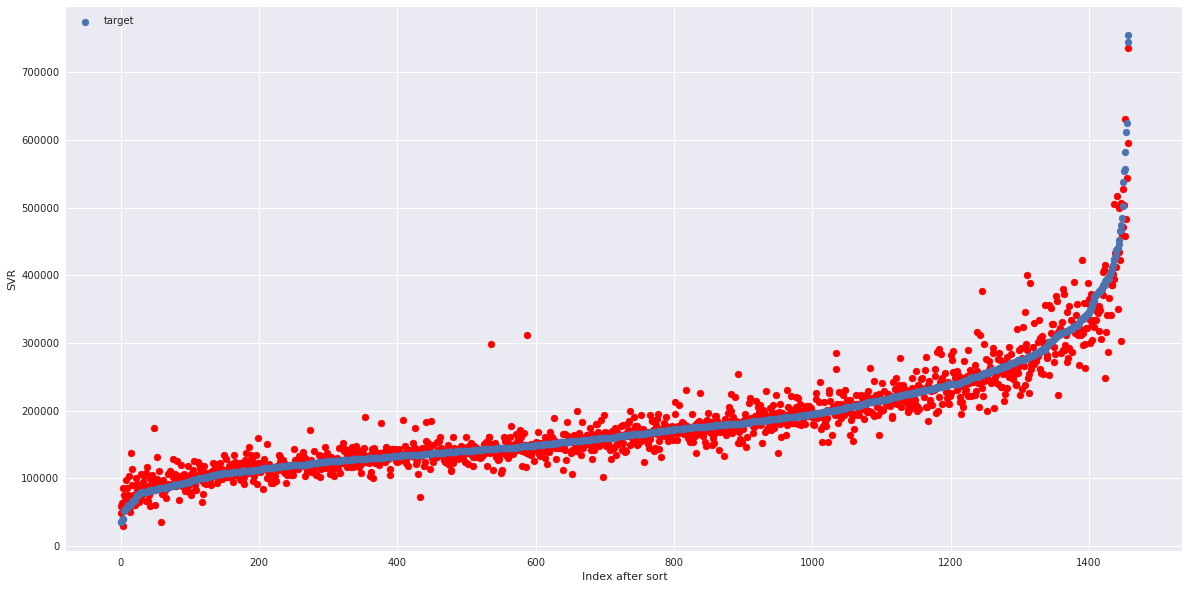

In [24]:
plot_matching(target_normal, y_pred)